
# ЛР: Шаблон обучения модели и проверка предсказаний (California Housing)

**Цель:** создать воспроизводимый шаблон для обучения модели регрессии, оценки качества и визуальной проверки предсказаний через графики остатков.

**Датасет:** `sklearn.datasets.fetch_california_housing(as_frame=True)`  
**Задача:** предсказать стоимость дома `MedHouseVal` по признакам.



> Авто-сгенерированный шаблон: 2025-10-08 16:26  
Рекомендуется запускать ячейки по порядку.


In [2]:
# !pip install -r requierments.txt

In [ ]:

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, get_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import numpy as np
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostRegressor
import time

p:\Python\practi5\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



# Загрузка данных


In [4]:

data = fetch_california_housing(as_frame=True)
df = data.frame.copy()
X = data.data.copy()
y = data.target.copy()

print(df.shape)
df.head()

(20640, 9)


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422


# Выборка

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16512, 8), (4128, 8), (16512,), (4128,))


# Модели и метрики


In [6]:
def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

In [8]:
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

pipeline_lr.fit(X_train, y_train)
pred_lr = pipeline_lr.predict(X_test)
metrics_lr = metrics(y_test, pred_lr)

rf = RandomForestRegressor(
    n_estimators=200, random_state=42, n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
metrics_rf = metrics(y_test, pred_rf)

print("LinearRegression:", metrics_lr)
print("RandomForestRegressor:", metrics_rf)

LinearRegression: {'MAE': 0.5332001304956565, 'RMSE': 0.7455813830127764, 'R2': 0.5757877060324508}
RandomForestRegressor: {'MAE': 0.3268118504360468, 'RMSE': 0.5039602414072009, 'R2': 0.8061857564039718}



# Графики остатков

In [16]:
def pred_vs_actual_plot(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()


def residuals_vs_pred_plot(y_true, y_pred, title):
    plt.figure()
    plt.scatter(y_pred, y_true - y_pred, alpha=0.5)
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.show()

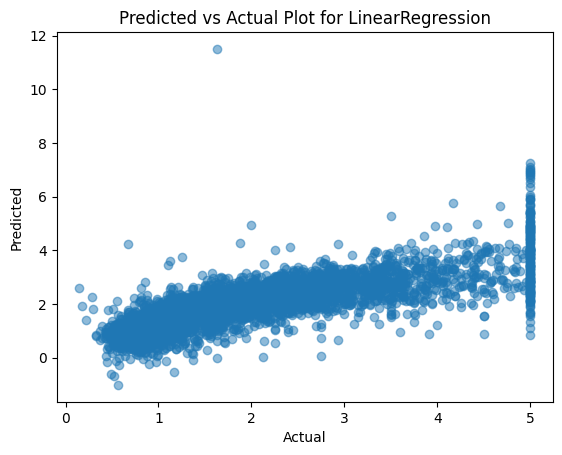

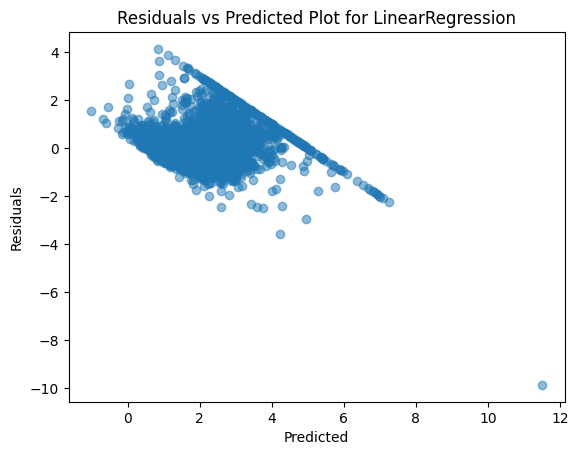

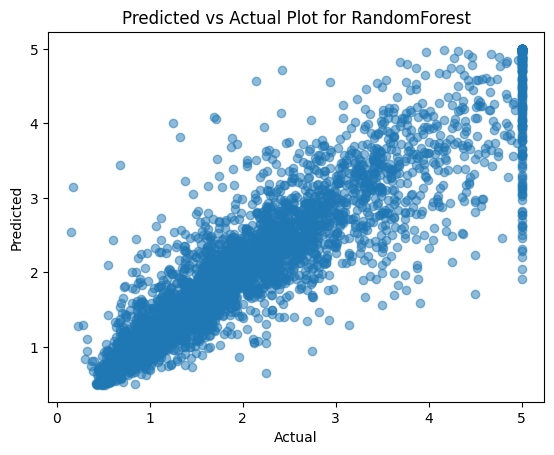

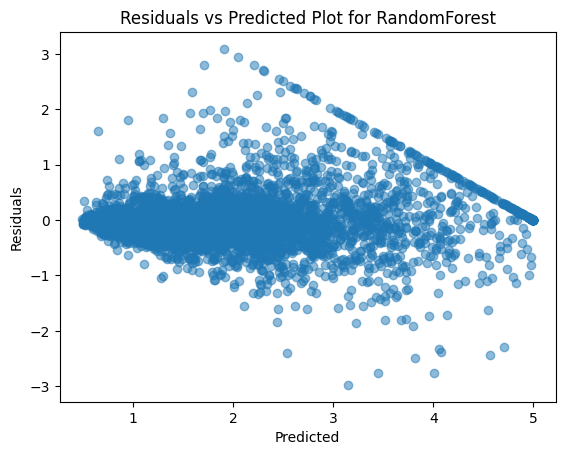

In [18]:
pred_vs_actual_plot(y_test.values, pred_lr,
                    title="Predicted vs Actual Plot for LinearRegression")
residuals_vs_pred_plot(y_test.values, pred_lr,
                       title="Residuals vs Predicted Plot for LinearRegression")

pred_vs_actual_plot(y_test.values, pred_rf,
                    title="Predicted vs Actual Plot for RandomForest")
residuals_vs_pred_plot(y_test.values, pred_rf,
                       title="Residuals vs Predicted Plot for RandomForest")

# Подбор гиперпараметров

In [19]:
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 600, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    base_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    crossvalidation = KFold(n_splits=3, shuffle=True, random_state=42)
    fold_scores = []

    indexes = np.arange(len(X_train))

    for fold_id, (train, valid) in enumerate(crossvalidation.split(indexes)):
        model = clone(base_model)

        X_tr = X_train.iloc[train]
        y_tr = y_train.iloc[train]
        X_vl = X_train.iloc[valid]
        y_vl = y_train.iloc[valid]

        try:
            model.fit(X_tr, y_tr)
            y_pr = model.predict(X_vl)
            score_rmse = rmse(y_vl, y_pr)
        except Exception as e:
            print(f"trial={trial.number} | fold {fold_id} error: {e}")
            score_rmse = float("inf")

        fold_scores.append(score_rmse)

        print(f"trial={trial.number} | fold {fold_id}: RMSE={score_rmse}")

    mean_rmse = float(np.mean(fold_scores)) if len(
        fold_scores) else float("inf")
    print(f"trial={trial.number} | mean RMSE={mean_rmse}")
    return -mean_rmse

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_rf, n_trials=30)

print("Best params:", study.best_params)
print("Best (neg-RMSE):", study.best_value)

[I 2025-10-09 11:20:00,919] A new study created in memory with name: no-name-33e916c7-871c-4bb3-a83a-6508a811f0cf


trial=0 | fold 0: RMSE=0.5125683526581741
trial=0 | fold 1: RMSE=0.5160682934220282


[I 2025-10-09 11:20:09,964] Trial 0 finished with value: -0.518143154654119 and parameters: {'n_estimators': 450, 'max_depth': 22, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.518143154654119.


trial=0 | fold 2: RMSE=0.5257928178821546
[trial 0] mean RMSE=0.518143154654119
trial=1 | fold 0: RMSE=0.5093743147077355
trial=1 | fold 1: RMSE=0.5125713730497278


[I 2025-10-09 11:20:21,108] Trial 1 finished with value: -0.5147887470382116 and parameters: {'n_estimators': 500, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: -0.5147887470382116.


trial=1 | fold 2: RMSE=0.5224205533571719
[trial 1] mean RMSE=0.5147887470382116
trial=2 | fold 0: RMSE=0.5204650251105217
trial=2 | fold 1: RMSE=0.5237944018760919


[I 2025-10-09 11:20:31,100] Trial 2 finished with value: -0.525357991987008 and parameters: {'n_estimators': 550, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.5147887470382116.


trial=2 | fold 2: RMSE=0.5318145489744105
[trial 2] mean RMSE=0.525357991987008
trial=3 | fold 0: RMSE=0.5182031455292274
trial=3 | fold 1: RMSE=0.5198188970421451


[I 2025-10-09 11:20:35,869] Trial 3 finished with value: -0.5231485754546564 and parameters: {'n_estimators': 250, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 1 with value: -0.5147887470382116.


trial=3 | fold 2: RMSE=0.531423683792597
[trial 3] mean RMSE=0.5231485754546564
trial=4 | fold 0: RMSE=0.5403599137750086
trial=4 | fold 1: RMSE=0.5440698319346527


[I 2025-10-09 11:20:40,053] Trial 4 finished with value: -0.5448447750857918 and parameters: {'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 1 with value: -0.5147887470382116.


trial=4 | fold 2: RMSE=0.5501045795477139
[trial 4] mean RMSE=0.5448447750857918
trial=5 | fold 0: RMSE=0.52409224813977
trial=5 | fold 1: RMSE=0.5251093317213924


[I 2025-10-09 11:20:45,103] Trial 5 finished with value: -0.5286749329945534 and parameters: {'n_estimators': 300, 'max_depth': 15, 'min_samples_split': 11, 'min_samples_leaf': 8}. Best is trial 1 with value: -0.5147887470382116.


trial=5 | fold 2: RMSE=0.5368232191224979
[trial 5] mean RMSE=0.5286749329945534
trial=6 | fold 0: RMSE=0.518862328533391
trial=6 | fold 1: RMSE=0.521492720771007


[I 2025-10-09 11:20:51,306] Trial 6 finished with value: -0.5243386960909717 and parameters: {'n_estimators': 350, 'max_depth': 29, 'min_samples_split': 19, 'min_samples_leaf': 4}. Best is trial 1 with value: -0.5147887470382116.


trial=6 | fold 2: RMSE=0.5326610389685175
[trial 6] mean RMSE=0.5243386960909717
trial=7 | fold 0: RMSE=0.5175782882094371
trial=7 | fold 1: RMSE=0.5204716379269383


[I 2025-10-09 11:20:53,181] Trial 7 finished with value: -0.523036080958069 and parameters: {'n_estimators': 100, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 6}. Best is trial 1 with value: -0.5147887470382116.


trial=7 | fold 2: RMSE=0.5310583167378317
[trial 7] mean RMSE=0.523036080958069
trial=8 | fold 0: RMSE=0.51072826798627
trial=8 | fold 1: RMSE=0.5133356358210807


[I 2025-10-09 11:20:57,446] Trial 8 finished with value: -0.5161101627845217 and parameters: {'n_estimators': 200, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: -0.5147887470382116.


trial=8 | fold 2: RMSE=0.5242665845462144
[trial 8] mean RMSE=0.5161101627845217
trial=9 | fold 0: RMSE=0.5280519779004789
trial=9 | fold 1: RMSE=0.5288167221261391


[I 2025-10-09 11:21:01,790] Trial 9 finished with value: -0.5326303565804743 and parameters: {'n_estimators': 250, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 1 with value: -0.5147887470382116.


trial=9 | fold 2: RMSE=0.5410223697148049
[trial 9] mean RMSE=0.5326303565804743
trial=10 | fold 0: RMSE=0.7765408872624743
trial=10 | fold 1: RMSE=0.7557083113194255


[I 2025-10-09 11:21:05,608] Trial 10 finished with value: -0.7656249798305611 and parameters: {'n_estimators': 600, 'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 1 with value: -0.5147887470382116.


trial=10 | fold 2: RMSE=0.7646257409097836
[trial 10] mean RMSE=0.7656249798305611
trial=11 | fold 0: RMSE=0.5105425837126044
trial=11 | fold 1: RMSE=0.5149806380204096


[I 2025-10-09 11:21:07,997] Trial 11 finished with value: -0.5163214325683709 and parameters: {'n_estimators': 100, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: -0.5147887470382116.


trial=11 | fold 2: RMSE=0.5234410759720988
[trial 11] mean RMSE=0.5163214325683709
trial=12 | fold 0: RMSE=0.5096111476176
trial=12 | fold 1: RMSE=0.5125973633174522


[I 2025-10-09 11:21:17,445] Trial 12 finished with value: -0.5149366440825469 and parameters: {'n_estimators': 450, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: -0.5147887470382116.


trial=12 | fold 2: RMSE=0.5226014213125887
[trial 12] mean RMSE=0.5149366440825469
trial=13 | fold 0: RMSE=0.514890812338467
trial=13 | fold 1: RMSE=0.5168446872976038


[I 2025-10-09 11:21:25,504] Trial 13 finished with value: -0.5198356503356696 and parameters: {'n_estimators': 450, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: -0.5147887470382116.


trial=13 | fold 2: RMSE=0.527771451370938
[trial 13] mean RMSE=0.5198356503356696
trial=14 | fold 0: RMSE=0.5092298581043223
trial=14 | fold 1: RMSE=0.5124681593766902


[I 2025-10-09 11:21:34,792] Trial 14 finished with value: -0.5147281206745385 and parameters: {'n_estimators': 450, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 14 with value: -0.5147281206745385.


trial=14 | fold 2: RMSE=0.522486344542603
[trial 14] mean RMSE=0.5147281206745385
trial=15 | fold 0: RMSE=0.5100948909586713
trial=15 | fold 1: RMSE=0.5141908520151334


[I 2025-10-09 11:21:45,566] Trial 15 finished with value: -0.5157090364354802 and parameters: {'n_estimators': 500, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 14 with value: -0.5147281206745385.


trial=15 | fold 2: RMSE=0.522841366332636
[trial 15] mean RMSE=0.5157090364354802
trial=16 | fold 0: RMSE=0.5213541322570097
trial=16 | fold 1: RMSE=0.5222425379774622


[I 2025-10-09 11:21:52,379] Trial 16 finished with value: -0.5259812136545721 and parameters: {'n_estimators': 400, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 14 with value: -0.5147281206745385.


trial=16 | fold 2: RMSE=0.5343469707292442
[trial 16] mean RMSE=0.5259812136545721
trial=17 | fold 0: RMSE=0.5288338787979922
trial=17 | fold 1: RMSE=0.5297648477836251


[I 2025-10-09 11:22:01,762] Trial 17 finished with value: -0.5330736401008782 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 14 with value: -0.5147281206745385.


trial=17 | fold 2: RMSE=0.5406221937210174
[trial 17] mean RMSE=0.5330736401008782
trial=18 | fold 0: RMSE=0.508071378370079
trial=18 | fold 1: RMSE=0.511162396833782


[I 2025-10-09 11:22:12,472] Trial 18 finished with value: -0.513452661805241 and parameters: {'n_estimators': 500, 'max_depth': 27, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 18 with value: -0.513452661805241.


trial=18 | fold 2: RMSE=0.5211242102118621
[trial 18] mean RMSE=0.513452661805241
trial=19 | fold 0: RMSE=0.720395335148817
trial=19 | fold 1: RMSE=0.710692030836126


[I 2025-10-09 11:22:15,099] Trial 19 finished with value: -0.7135632863096527 and parameters: {'n_estimators': 350, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 18 with value: -0.513452661805241.


trial=19 | fold 2: RMSE=0.7096024929440151
[trial 19] mean RMSE=0.7135632863096527
trial=20 | fold 0: RMSE=0.5074990005753316
trial=20 | fold 1: RMSE=0.5109023512503398


[I 2025-10-09 11:22:27,119] Trial 20 finished with value: -0.512985496671854 and parameters: {'n_estimators': 550, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 20 with value: -0.512985496671854.


trial=20 | fold 2: RMSE=0.5205551381898909
[trial 20] mean RMSE=0.512985496671854
trial=21 | fold 0: RMSE=0.5075440927819469
trial=21 | fold 1: RMSE=0.5108737361234317


[I 2025-10-09 11:22:39,531] Trial 21 finished with value: -0.5130150824967606 and parameters: {'n_estimators': 550, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 20 with value: -0.512985496671854.


trial=21 | fold 2: RMSE=0.5206274185849035
[trial 21] mean RMSE=0.5130150824967606
trial=22 | fold 0: RMSE=0.511771643451041
trial=22 | fold 1: RMSE=0.5145924588758578


[I 2025-10-09 11:22:50,012] Trial 22 finished with value: -0.5170849144870447 and parameters: {'n_estimators': 550, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 20 with value: -0.512985496671854.


trial=22 | fold 2: RMSE=0.5248906411342354
[trial 22] mean RMSE=0.5170849144870447
trial=23 | fold 0: RMSE=0.5074990005753316
trial=23 | fold 1: RMSE=0.5109023512503398


[I 2025-10-09 11:23:02,816] Trial 23 finished with value: -0.512985496671854 and parameters: {'n_estimators': 550, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 20 with value: -0.512985496671854.


trial=23 | fold 2: RMSE=0.5205551381898909
[trial 23] mean RMSE=0.512985496671854
trial=24 | fold 0: RMSE=0.5095995067041824
trial=24 | fold 1: RMSE=0.5127429077165954


[I 2025-10-09 11:23:15,072] Trial 24 finished with value: -0.5149515449514306 and parameters: {'n_estimators': 550, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 20 with value: -0.512985496671854.


trial=24 | fold 2: RMSE=0.522512220433514
[trial 24] mean RMSE=0.5149515449514306
trial=25 | fold 0: RMSE=0.5074376763991965
trial=25 | fold 1: RMSE=0.5112883780789578


[I 2025-10-09 11:23:31,976] Trial 25 finished with value: -0.5127968316167374 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 25 with value: -0.5127968316167374.


trial=25 | fold 2: RMSE=0.5196644403720577
[trial 25] mean RMSE=0.5127968316167374
trial=26 | fold 0: RMSE=0.5074376763991965
trial=26 | fold 1: RMSE=0.5112883780789578


[I 2025-10-09 11:23:48,305] Trial 26 finished with value: -0.5127968316167374 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 25 with value: -0.5127968316167374.


trial=26 | fold 2: RMSE=0.5196644403720577
[trial 26] mean RMSE=0.5127968316167374
trial=27 | fold 0: RMSE=0.5103823704408772
trial=27 | fold 1: RMSE=0.5138194877554239


[I 2025-10-09 11:24:00,915] Trial 27 finished with value: -0.5155595472777836 and parameters: {'n_estimators': 600, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 25 with value: -0.5127968316167374.


trial=27 | fold 2: RMSE=0.5224767836370497
[trial 27] mean RMSE=0.5155595472777836
trial=28 | fold 0: RMSE=0.5078326552302191
trial=28 | fold 1: RMSE=0.5113146949116604


[I 2025-10-09 11:24:15,285] Trial 28 finished with value: -0.5130508626588964 and parameters: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 25 with value: -0.5127968316167374.


trial=28 | fold 2: RMSE=0.5200052378348098
[trial 28] mean RMSE=0.5130508626588964
trial=29 | fold 0: RMSE=0.5079421016218483
trial=29 | fold 1: RMSE=0.5115630266788851


[I 2025-10-09 11:24:27,538] Trial 29 finished with value: -0.5133072445303318 and parameters: {'n_estimators': 500, 'max_depth': 22, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 25 with value: -0.5127968316167374.


trial=29 | fold 2: RMSE=0.5204166052902623
[trial 29] mean RMSE=0.5133072445303318
Best params: {'n_estimators': 600, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best (neg-RMSE): -0.5127968316167374


# Фабрика

In [ ]:
def gen_objective(estimator_class, grid, X_train, y_train,
                  *, cv=3, scorer="neg_root_mean_squared_error",
                  fit_params=None, random_state=42, n_jobs=-1, verbose=True):
    fit_params = {} if fit_params is None else dict(fit_params)

    if not isinstance(grid, dict) or not grid:
        raise ValueError(
            "grid must be not empty dict ({param: (type, ...)})")

    def suggest_param(trial, name, spec):
        if not isinstance(spec, (tuple, list)) or not spec:
            raise ValueError(f"Error spec {name}: {spec}")
        ptype = spec[0]
        if ptype == "int":
            low, high = spec[1], spec[2]
            step = spec[3] if len(spec) > 3 else 1
            return trial.suggest_int(name, int(low), int(high), step=int(step))
        elif ptype == "float":
            low, high = float(spec[1]), float(spec[2])
            log = bool(spec[3]) if len(spec) > 3 else False
            return trial.suggest_float(name, low, high, log=log)
        elif ptype == "categorical":
            choices = list(spec[1])
            return trial.suggest_categorical(name, choices)
        elif ptype == "loguniform":
            low, high = float(spec[1]), float(spec[2])
            return trial.suggest_float(name, low, high, log=True)
        else:
            raise ValueError(
                f"Error space type {ptype} for {name}")

    if isinstance(scorer, str):
        try:
            scorer_obj = get_scorer(scorer)
        except Exception:
            if verbose:
                print(
                    f"Error scorer={scorer}")
            scorer_obj = get_scorer("neg_root_mean_squared_error")
    else:
        scorer_obj = scorer

    idx = np.arange(len(X_train))

    def objective(trial):
        t0 = time()

        params = {name: suggest_param(trial, name, spec)
                  for name, spec in grid.items()}

        try:
            probe = estimator_class()
            base_params = getattr(probe, "get_params", lambda: {})()
        except Exception:
            base_params = {}

        model_kwargs = {}
        if "random_state" in base_params:
            model_kwargs["random_state"] = random_state
        if "n_jobs" in base_params:
            model_kwargs["n_jobs"] = n_jobs

        model = estimator_class(**model_kwargs, **params)

        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        fold_scores = []

        for fold_id, (tr_idx, vl_idx) in enumerate(kf.split(idx), start=1):
            m = clone(model)
            X_tr = X_train.iloc[tr_idx]
            y_tr = y_train.iloc[tr_idx]
            X_vl = X_train.iloc[vl_idx]
            y_vl = y_train.iloc[vl_idx]

            try:
                m.fit(X_tr, y_tr, **fit_params)
                s = scorer_obj(m, X_vl, y_vl)
                s = float(s)
                if not np.isfinite(s):
                    if verbose:
                        print(
                            f"trial={trial.number} | fold {fold_id}: score is not finite, set to -1e12")
                    s = -1e12
            except Exception as e:
                if verbose:
                    print(
                        f"trial={trial.number} | fold {fold_id} error: {e}")
                s = -1e12

            fold_scores.append(s)

            if verbose:
                print(f"trial {trial.number} | fold {fold_id} score={s}")

        mean_score = float(np.mean(fold_scores)) if fold_scores else -1e12
        if not np.isfinite(mean_score):
            mean_score = -1e12

        if verbose:
            dt = time() - t0
            print(
                f"trial={trial.number} | mean_score={mean_score} | time={dt} | params={params}")

        return mean_score

    return objective

In [ ]:

rf_grid = {
    "n_estimators": ("int", 100, 600, 50),
    "max_depth": ("int", 3, 30),
    "min_samples_split": ("int", 2, 20),
    "min_samples_leaf": ("int", 1, 10),
}
objective = gen_objective(RandomForestRegressor, rf_grid, X_train, y_train, cv=3)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("Best RF:", study.best_params, "score:", study.best_value)

best_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **study.best_params)
best_rf.fit(X_train, y_train)
pred_best_rf = best_rf.predict(X_test)
metrics(y_test, pred_best_rf)

pred_vs_actual_plot(y_test.values, pred_best_rf, title="Predicted vs Actual (Best RF)")
residuals_vs_pred_plot(y_test.values, pred_best_rf, title="Residuals vs Predicted (Best RF)")


In [ ]:
from catboost import CatBoostRegressor

catboost_grid = {
    "depth": ("int", 4, 10),
    "learning_rate": ("loguniform", 1e-3, 0.3),
    "l2_leaf_reg": ("loguniform", 1e-2, 10.0),
    "iterations": ("int", 200, 1500, 100),
}

objective_cb = gen_objective(
    CatBoostRegressor, catboost_grid, X_train, y_train,
    cv=3,
    fit_params={"verbose": False}
)

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=30)
print("Best CatBoost:", study_cb.best_params, "score:", study_cb.best_value)

best_cb = CatBoostRegressor(**study_cb.best_params, verbose=False)
best_cb.fit(X_train, y_train)
pred_best_cb = best_cb.predict(X_test)
metrics(y_test, pred_best_cb)

pred_vs_actual_plot(y_test.values, pred_best_cb, title="Predicted vs Actual (Best CatBoost)")
residuals_vs_pred_plot(y_test.values, pred_best_cb, title="Residuals vs Predicted (Best CatBoost)")
